# MLP:
The first half of this notebook may be used to train an MLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_batches, shuffle, train_val_split, preds_to_scores, scores_to_preds
from src.mlp import MLP
from src.rnn import RNN

%load_ext autoreload
%autoreload 2

In [2]:
# Define the path to the data. This is the training dataframe saved from the preprocessing notebook.
data_path = './data/train_df.pkl'
train_df = pd.read_pickle(data_path)

In [35]:
# To further isolate our data, we will only examine essays from a single set
# Feel free to experiment with different essay sets!

set = 4
df = train_df.loc[train_df['essay_set'] == set]
df.head()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score,essays_embed,word_count,min_score,max_score,norm_score
5309,8863,4,0,0,0,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",43,0.0,4.0,0
5310,8864,4,0,0,0,"[[0.15637, -0.40361, -0.29629, -0.34259, -0.18...",28,0.0,4.0,0
5311,8865,4,3,2,3,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",111,0.0,4.0,9
5312,8866,4,1,2,2,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",52,0.0,4.0,6
5313,8867,4,2,2,2,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",104,0.0,4.0,6


In [36]:
# We should get a plot here to examine score distribution for this set

# In order to avoid bias toward more common scores, we will limit the number
# of essays from each scoring bucket to a set value
score_df = None
min_score = int(df['min_score'].min())
max_score = int(df['max_score'].max())

n_max = 100
for i in range(min_score,max_score+1):
    if score_df is None:
        score_df = df.loc[df['domain1_score'] == i][:n_max]
    else:
        temp_df = df.loc[df['domain1_score'] == i][:n_max]
        score_df = pd.concat([score_df, temp_df])
df = score_df

In [37]:
# Extract essay vectors and corresponding scores
X = np.array(df['essays_embed'])
y = np.array(df['domain1_score'])
X = np.stack(X, axis=0)
print('There are {} training essays, each of shape {} x {}'.format(X.shape[0], X.shape[1], X.shape[2]))

There are 369 training essays, each of shape 120 x 200


These essays are the wrong shape to feed directly into the MLP. Therefore, each essay matrix needs to be flattened into a 1-D vector.

In [38]:
X_flatten = np.reshape(X, [X.shape[0], -1])
print('There are {} training essays, each a vector of length {}'.format(X_flatten.shape[0], X_flatten.shape[1]))

There are 369 training essays, each a vector of length 24000


The next step is to shuffle the data and separate it into training and validation sets.

In [39]:
X, y = shuffle(X_flatten, y)

X_train, y_train, X_val, y_val = train_val_split(X, y, train_prop=0.85)

Here we need to transform the labels to the form that the network will predict. For example, in set 1, the essays are graded on a scale from 2-12, therefore there are 11 classes into which the network will try to classify each essay. However, the network will classify essays into the scale 0-10. Therefore, this step will perform this shift on the labels. If the scoring range already starts at 0, no shift is performed.

In [56]:
if min_score != 0:
    y_train_adj = scores_to_preds(y_train, min_score)
    print('Training labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_train),max(y_train), min(y_train_adj), max(y_train_adj)))
    y_val_adj = scores_to_preds(y_val, min_score)
    print('Validation labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_val),max(y_val), min(y_val_adj), max(y_val_adj)))
else:
    print('No score adjustment necessary')
    y_train_adj = y_train
    y_val_adj = y_val

No score adjustment necessary


Enter the name of the model you're training here. The model will be saved to the 'model/' directory of this project. Then choose other parameters such as learning rate, number of training epochs, l2 regularization, dropout probability, and regression vs classification. All other parameters are derived and do not need to be set manually.

In [41]:
# User Defined Parameters
model_name = 'mlp_set1'
hidden_dims = [100,30]
weight_scale = 1e-2
batch_size = 16
n_epochs = 5
l2_reg = 1e-4
keep_prob = 0.8
reg = True
lr = 1e-3

# Derived Parameters
input_dim = X_train.shape[1]
num_classes = max_score-min_score + 1
n_batches = round(X_train.shape[0]/batch_size)
batch_gen = get_batches(X_train, y_train_adj, batch_size, net_type='mlp')

mlp_net = MLP(input_dim=input_dim, hidden_dims=hidden_dims, num_classes=num_classes, weight_scale=weight_scale,\
              l2_reg=l2_reg, keep_prob=keep_prob, regression=reg)

In [42]:
train_loss_hist, val_loss_hist = mlp_net.train(gen=batch_gen, X_val=X_val, y_val=y_val_adj, n_epochs=n_epochs, n_batches=n_batches, lr=lr,\
                                               save_every_n=5, model_name=model_name)

Epoch 1, Batch 1 -- Loss: 2.047 Validation accuracy: 0.200
Sample Grade Predictions: 
Preds:   0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0
Actual:  2 2 2 0 3 0 2 2 2 1 1 2 2 0 0 2 3 1 2 2
Best validation accuracy! - Saving Model


Epoch 2, Batch 1 -- Loss: 1.128 Validation accuracy: 0.182
Sample Grade Predictions: 
Preds:   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
Actual:  2 2 2 0 3 0 2 2 2 1 1 2 2 0 0 2 3 1 2 2


Epoch 3, Batch 1 -- Loss: 1.108 Validation accuracy: 0.200
Sample Grade Predictions: 
Preds:   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
Actual:  2 2 2 0 3 0 2 2 2 1 1 2 2 0 0 2 3 1 2 2


Epoch 4, Batch 1 -- Loss: 2.245 Validation accuracy: 0.200
Sample Grade Predictions: 
Preds:   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
Actual:  2 2 2 0 3 0 2 2 2 1 1 2 2 0 0 2 3 1 2 2


Epoch 5, Batch 1 -- Loss: 1.041 Validation accuracy: 0.236
Sample Grade Predictions: 
Preds:   2 1 1 1 1 1 2 1 1 1 2 1 2 2 1 1 2 1 2 1
Actual:  2 2 2 0 3 0 2 2 2 1 1 2 2 0 0 2 3 1 2 2
Best validation accuracy! - Saving Model


Best validation accuracy over the training period was: 0.23636363446712494%


In [43]:
# Extract Loss data for plotting
x = []
train_loss = []
val_loss = []
for k,v in train_loss_hist.items():
    x.append(k[0]-1+k[1]/n_batches)
    train_loss.append(v)
    val_loss.append(val_loss_hist[k])

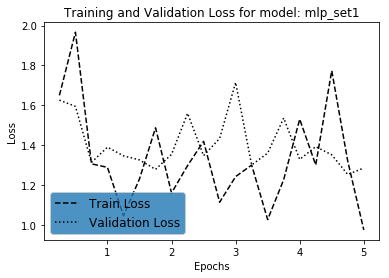

In [44]:
fig, ax = plt.subplots()
ax.plot(x, train_loss, 'k--', label='Train Loss')
ax.plot(x, val_loss, 'k:', label='Validation Loss')

legend = ax.legend(loc='lower left', shadow=False, fontsize='large')
legend.get_frame().set_facecolor('C0')
plt.title('Training and Validation Loss for model: '+model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [48]:
preds = mlp_net.predict('./model/'+model_name, X_val)

# We need to map predictions from classes in the model to actual scores
preds = preds_to_scores(preds, min_score=min_score)

INFO:tensorflow:Restoring parameters from ./model/mlp_set1


In [49]:
from src.preprocess import quadratic_weighted_kappa

quadratic_weighted_kappa(y_val, preds)

0.16105877074921493

# RNN:
The second half of this notebook may be used for training an RNN - specifically an LSTM or GRU

In [58]:
# Define the path to the data
data_path = './data/train_df.pkl'
train_df = pd.read_pickle(data_path)

# To further isolate our data, we will only examine essays from a single set
# Feel free to experiment with different essay sets!
set = 4
df = train_df.loc[train_df['essay_set'] == set]
df.head()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score,essays_embed,word_count,min_score,max_score,norm_score
5309,8863,4,0,0,0,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",43,0.0,4.0,0
5310,8864,4,0,0,0,"[[0.15637, -0.40361, -0.29629, -0.34259, -0.18...",28,0.0,4.0,0
5311,8865,4,3,2,3,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",111,0.0,4.0,9
5312,8866,4,1,2,2,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",52,0.0,4.0,6
5313,8867,4,2,2,2,"[[-0.46765, 0.46369, 0.21761, -0.63619, 0.2019...",104,0.0,4.0,6


In [59]:
# In order to avoid bias toward more common scores, we will limit the number
# of essays from each scoring bucket to a set value
score_df = None
min_score = int(df['min_score'].min())
max_score = int(df['max_score'].max())

n_max = 100
for i in range(min_score,max_score+1):
    if score_df is None:
        score_df = df.loc[df['domain1_score'] == i][:n_max]
    else:
        temp_df = df.loc[df['domain1_score'] == i][:n_max]
        score_df = pd.concat([score_df, temp_df])
df = score_df

In [60]:
# Extract essay vectors and corresponding scores
X = np.array(df['essays_embed'])
y = np.array(df['domain1_score'])
X = np.stack(X, axis=0)
print('There are {} training essays, each of shape {} x {}'.format(X.shape[0], X.shape[1], X.shape[2]))

There are 369 training essays, each of shape 120 x 200


The next step is to shuffle the data and separate it into training and validation sets.

In [61]:
X, y = shuffle(X, y)
X_train, y_train, X_val, y_val = train_val_split(X, y, train_prop=0.85)

Here we need to transform the labels to the form that the network will predict. For example, in set 1, the essays are graded on a scale from 2-12, therefore there are 11 classes into which the network will try to classify each essay. However, the network will classify essays into the scale 0-10. Therefore, this step will perform this shift on the labels.

In [62]:
if min_score != 0:
    y_train_adj = scores_to_preds(y_train, min_score)
    print('Training labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_train),max(y_train), min(y_train_adj), max(y_train_adj)))
    y_val_adj = scores_to_preds(y_val, min_score)
    print('Validation labels shifted from a scale of ({},{}) to ({},{})'\
          .format(min(y_val),max(y_val), min(y_val_adj), max(y_val_adj)))
else:
    print('No score adjustment necessary')
    y_train_adj = y_train
    y_val_adj = y_val

No score adjustment necessary


In [ ]:
# User Defined Parameters
model_name = 'gru_set4'
batch_size = 32
n_epochs = 10
l2_reg = 1e-4
keep_prob = 0.8
reg = True
lr = 1e-3

# Derived Parameters
input_dim = X_train.shape[1]
num_classes = max_score-min_score + 1
n_batches = round(X_train.shape[0]/batch_size)
batch_gen = get_batches(X_train, y_train_adj, batch_size, net_type='mlp')

mlp_net = MLP(input_dim=input_dim, hidden_dims=hidden_dims, num_classes=num_classes, weight_scale=weight_scale,\
              l2_reg=l2_reg, keep_prob=keep_prob, regression=reg)

In [77]:
# User Defined Parameters
model_name = 'gru_set4'
batch_size = 32
cell_type = 'gru'
rnn_size = 128
lr = 5e-3

# Derived Parameters
num_classes = max_score-min_score + 1
n_batches = round(X_train.shape[0]/batch_size)
seq_length = X_train.shape[1]
embed_size = X_train.shape[2]

X_val_t = X_val[:batch_size]
y_val_t = y_val[:batch_size]
batch_gen = get_batches(X_train, y_train_adj, batch_size, net_type=cell_type)

my_net = RNN(num_classes, batch_size, seq_length, embed_size, cell_type=cell_type,
                 rnn_size=rnn_size, num_layers=2, learning_rate=lr, train_keep_prob=1)

In [83]:
print('Training Network...')
train_loss_hist, val_loss_hist = my_net.train(batch_gen, X_val_t, y_val_t,\
                                              n_epochs, n_batches, save_every_n=5,\
                                              model_name=model_name)

Training Network...


---------- Training epoch: 1 ----------

Epoch 1, step 5 loss: 1.3769  validation accuracy: 0.40625  0.1692 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   2 0 0 0 2 0 0 0 0 2 0 2 0 0 0 2 0 0 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 1, step 10 loss: 1.2243  validation accuracy: 0.53125  0.1701 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   3 2 0 2 3 3 0 0 2 3 2 3 0 2 3 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 2 ----------

Epoch 2, step 5 loss: 0.9285  validation accuracy: 0.46875  0.1830 sec/batch
Sample Grade Predictions: 
Preds:   3 0 0 0 3 2 0 0 2 3 2 3 0 0 2 3 2 0 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 2, step 10 loss: 1.0555  validation accuracy: 0.5  0.1765 sec/batch
Sample Grade Predictions: 
Preds:   3 1 1 1 3 2 1 0 2 3 2 3 0 1 2 2 2 2 2 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 3 ----------

Epoch 3, step 5 loss: 1.0565  validation accuracy: 0.5625  0.1945 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   2 1 0 1 2 2 0 0 2 2 2 3 0 0 2 2 2 2 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 3, step 10 loss: 1.0094  validation accuracy: 0.53125  0.1838 sec/batch
Sample Grade Predictions: 
Preds:   3 1 0 1 3 2 0 0 2 3 2 3 0 1 2 3 2 1 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 4 ----------

Epoch 4, step 5 loss: 1.0015  validation accuracy: 0.59375  0.1721 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   3 1 0 1 3 2 0 0 2 3 2 3 0 1 2 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 4, step 10 loss: 1.0195  validation accuracy: 0.59375  0.1694 sec/batch
Sample Grade Predictions: 
Preds:   3 1 0 1 3 2 0 0 2 3 2 3 0 1 2 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 5 ----------

Epoch 5, step 5 loss: 0.7677  validation accuracy: 0.59375  0.1702 sec/batch
Sample Grade Predictions: 
Preds:   3 1 0 1 3 2 0 0 2 3 2 3 0 1 2 2 1 1 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 5, step 10 loss: 1.0745  validation accuracy: 0.5  0.1698 sec/batch
Sample Grade Predictions: 
Preds:   3 1 0 2 3 2 0 0 2 3 2 3 0 1 2 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 6 ----------

Epoch 6, step 5 loss: 1.1863  validation accuracy: 0.53125  0.1684 sec/batch
Sample Grade Predictions: 
Preds:   2 0 0 1 2 2 0 0 1 2 2 2 0 0 1 2 1 1 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 6, step 10 loss: 0.8708  validation accuracy: 0.34375  0.1717 sec/batch
Sample Grade Predictions: 
Preds:   3 1 1 2 3 2 1 1 2 3 2 3 1 1 2 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 7 ----------

Epoch 7, step 5 loss: 0.7561  validation accuracy: 0.5625  0.1709 sec/batch
Sample Grade Predictions: 
Preds:   3 0 0 1 3 2 0 0 1 3 2 3 0 0 1 3 1 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 7, step 10 loss: 0.9269  validation accuracy: 0.65625  0.1697 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   2 0 0 1 3 2 0 0 1 2 2 3 0 0 1 2 1 2 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 8 ----------

Epoch 8, step 5 loss: 1.1507  validation accuracy: 0.5  0.1673 sec/batch
Sample Grade Predictions: 
Preds:   2 1 1 1 3 2 1 1 1 3 2 3 1 1 1 2 1 2 2 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 8, step 10 loss: 1.0571  validation accuracy: 0.5625  0.1763 sec/batch
Sample Grade Predictions: 
Preds:   3 0 0 2 3 2 0 0 2 3 2 3 0 1 1 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 9 ----------

Epoch 9, step 5 loss: 1.0009  validation accuracy: 0.59375  0.1708 sec/batch
Sample Grade Predictions: 
Preds:   2 0 0 2 3 2 0 0 2 2 2 3 0 0 1 3 2 2 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 9, step 10 loss: 0.7109  validation accuracy: 0.71875  0.1727 sec/batch
Best validation accuracy! - Saving Model
Sample Grade Predictions: 
Preds:   2 0 0 1 3 2 0 0 2 2 2 3 0 0 1 2 2 2 2 2
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


---------- Training epoch: 10 ----------

Epoch 10, step 5 loss: 0.7490  validation accuracy: 0.625  0.2038 sec/batch
Sample Grade Predictions: 
Preds:   2 0 0 2 3 2 0 0 2 3 2 3 0 1 1 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3


Epoch 10, step 10 loss: 0.6902  validation accuracy: 0.625  0.1989 sec/batch
Sample Grade Predictions: 
Preds:   2 0 0 2 3 2 0 0 2 3 2 3 0 1 1 3 2 2 3 3
Actual:  2 0 0 1 3 1 0 0 3 2 2 3 1 1 3 2 2 2 2 3
Best validation accuracy over the training period was: 0.71875%


In [84]:
# Extract Loss data for plotting
x = []
train_loss = []
val_loss = []
for k,v in train_loss_hist.items():
    x.append(k[0]-1+k[1]/n_batches)
    train_loss.append(v)
    val_loss.append(val_loss_hist[k])

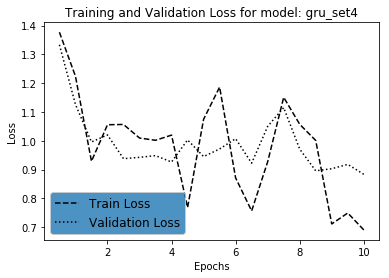

In [85]:
fig, ax = plt.subplots()
ax.plot(x, train_loss, 'k--', label='Train Loss')
ax.plot(x, val_loss, 'k:', label='Validation Loss')

legend = ax.legend(loc='lower left', shadow=False, fontsize='large')
legend.get_frame().set_facecolor('C0')
plt.title('Training and Validation Loss for model: '+model_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [86]:
batch_size = X_val.shape[0]
seq_length = X_val.shape[1]
embed_size = X_val.shape[2]

pred_net = RNN(num_classes, batch_size, seq_length, embed_size, cell_type=cell_type,
                 rnn_size=rnn_size, num_layers=2, learning_rate=lr, train_keep_prob=1)
preds = pred_net.predict('./model/best_model_rnn', X_val)
preds = scores_to_preds(preds, min_score)

INFO:tensorflow:Restoring parameters from ./model/best_model_rnn


Running network predictions


In [87]:
from src.preprocess import quadratic_weighted_kappa
quadratic_weighted_kappa(preds[0], y_val)

0.8628086804689449